# ДЗ к Уроку 1. Обработка изображений и компьютерное зрение.

Напишите на Python реализацию как минимум одного алгоритма на выбор: любая на выбор цветовая обработка, перевод в другое цветовое пространство или фильтрация. Изображение выберите самостоятельно.

### Подготовка

mode:5


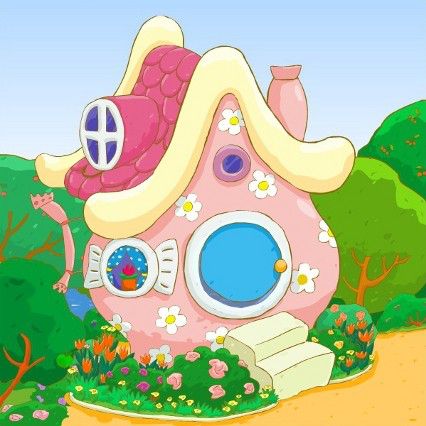

In [37]:
import random
from PIL import Image, ImageDraw #Подключим необходимые библиотеки. 

mode = int(input('mode:')) #Считываем номер преобразования. 
image = Image.open("temp.jpg") #Открываем изображение. 
draw = ImageDraw.Draw(image) #Создаем инструмент для рисования. 
width = image.size[0] #Определяем ширину. 
height = image.size[1] #Определяем высоту. 	
pix = image.load() #Выгружаем значения пикселей.
image

### Оттенки серого
Для получения этого преобразования необходимо «усреднить» каждый пиксел.

In [ ]:
if (mode == 0):
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            S = (a + b + c) // 3
            draw.point((i, j), (S, S, S))
    image.save("grey.jpg", "JPEG")

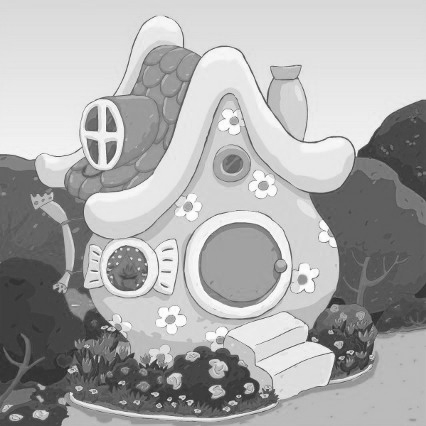

In [8]:
image

### Сепия
Чтобы получить сепию, нужно посчитать среднее значение и взять какой — нибудь коэффициент.

middle = (R + G + B) / 3

Первое значение пиксела ( R ) = middle + 2 * k

Второе значение пиксела ( G ) = middle + k

Третье значение пиксела ( B ) = middle

In [13]:
if (mode == 1):
    depth = int(input('depth:'))
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            S = (a + b + c) // 3
            a = S + depth * 2
            b = S + depth
            c = S
            if (a > 255):
                a = 255
            if (b > 255):
                b = 255
            if (c > 255):
                c = 255
            draw.point((i, j), (a, b, c))
    image.save("sepia.jpg", "JPEG")

depth:10


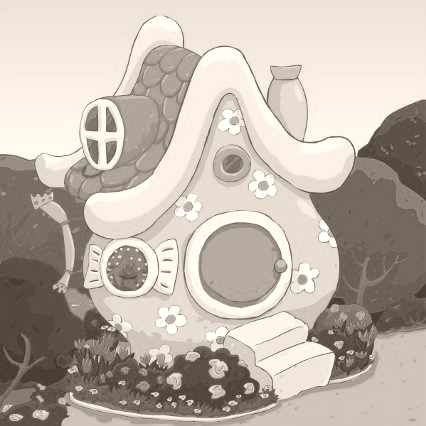

In [14]:
image

### Негатив

Теперь научимся получать негатив.
Это очень просто, достаточно лишь каждое значение пиксела вычесть из 255.

In [19]:
if (mode == 2):
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            draw.point((i, j), (255 - a, 255 - b, 255 - c))
    image.save("negative.jpg", "JPEG")

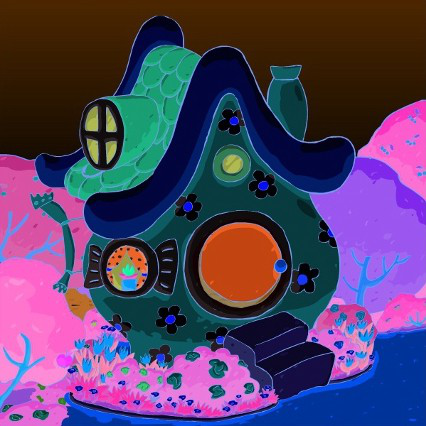

In [20]:
image

### Добавление шумов

Вот тут совсем всё просто.
Мы будем всегда добавлять к пикселу какое — нибудь рандомное значение. Чем больше разброс этих значений, тем больше шумов.

In [28]:
if (mode == 3):
    factor = int(input('factor:'))
    for i in range(width):
        for j in range(height):
            rand = random.randint(-factor, factor)
            a = pix[i, j][0] + rand
            b = pix[i, j][1] + rand
            c = pix[i, j][2] + rand
            if (a < 0):
                a = 0
            if (b < 0):
                b = 0
            if (c < 0):
                c = 0
            if (a > 255):
                a = 255
            if (b > 255):
                b = 255
            if (c > 255):
                c = 255
            draw.point((i, j), (a, b, c))
    image.save("noise.jpg", "JPEG")

factor:30


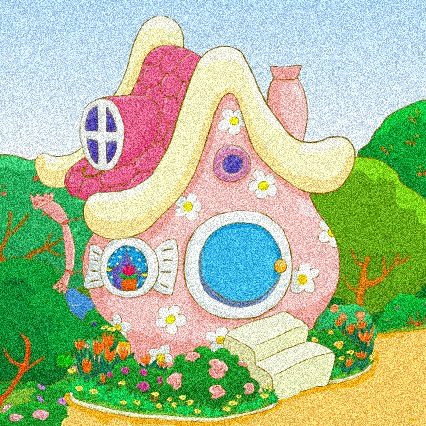

In [29]:
image

### Яркость

Для регулирования яркости к каждому пикселу мы будем добавлять определенное значение. Если оно > 0, то картинка становится ярче, иначе темнее.

In [35]:
if (mode == 4):
    factor = int(input('factor:'))
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0] + factor
            b = pix[i, j][1] + factor
            c = pix[i, j][2] + factor
            if (a < 0):
                a = 0
            if (b < 0):
                b = 0
            if (c < 0):
                c = 0
            if (a > 255):
                a = 255
            if (b > 255):
                b = 255
            if (c > 255):
                c = 255
            draw.point((i, j), (a, b, c))
    image.save("bright.jpg", "JPEG")

factor:-50


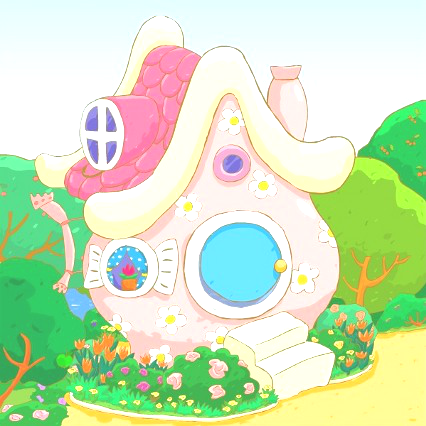

In [34]:
image

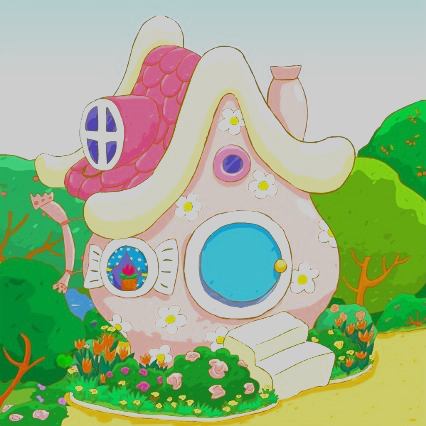

In [36]:
image

### Чёрно — белое изображение

Теперь все пикселы надо разбить на 2 группы: черные и белые.
Для проверки принадлежности к определенной группе мы будем смотреть к чему ближе значение пиксела: к белому цвету или к чёрному.

In [38]:
if (mode == 5):
    factor = int(input('factor:'))
    for i in range(width):
        for j in range(height):
            a = pix[i, j][0]
            b = pix[i, j][1]
            c = pix[i, j][2]
            S = a + b + c
            if (S > (((255 + factor) // 2) * 3)):
                a, b, c = 255, 255, 255
            else:
                a, b, c = 0, 0, 0
            draw.point((i, j), (a, b, c))
    image.save("b&w.jpg", "JPEG")

factor:50


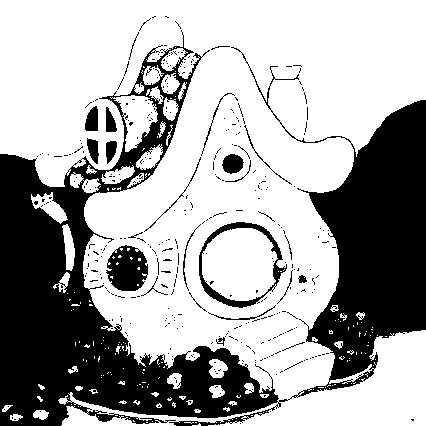

In [39]:
image

In [15]:
del draw